#Two Layers Autoencoder

This notebook is devoted to the study of a two layers autoencoder on step functions with same amplitude. The experiments are based on a theoretical study found in sections 4.1 and 4.2 in [this paper](https://github.com/HeleneMaxcici/Autoencoder-Study/blob/master/Autoencoder_Study_02-01-2022.pdf).

We test the theoretical results by training the autoencoder for each of the activations: Linear, ReLU and Sigmoid. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Optimizer

from ae_functionalities import stepfunctions, AutoEncoder

### Data
First we create the dataset.

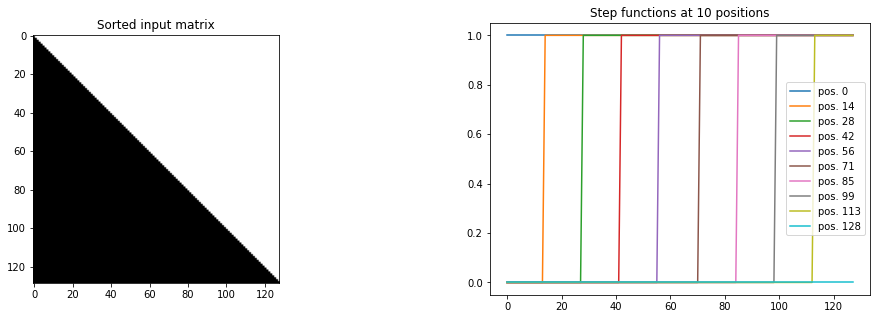

In [2]:
# Creating the dataset
left_amp = [0] 
right_amp = [1] #step functions of amplitude 1

n=128 #dimension of the step functions

X_test = stepfunctions(n, left_amp, right_amp) #sorted matrix of step functions

#permuting samples
r = torch.randperm(X_test.shape[0])
X = X_test[r,:]

#visualization of the matrix
plt.figure(figsize = (15,5))

plt.subplot(1,3,1)
plt.imshow(X_test, cmap='gray')
plt.title("Sorted input matrix")

plt.subplot(1,2,2)
for i in np.linspace(0,n,10,dtype=int):
  plt.plot(X_test[i], label=f"pos. {i}");
plt.title("Step functions at 10 positions")
plt.legend()

### Autoencoder architecture

In [3]:
class Encoder(nn.Module):
# This is a one layer encoder 
   
  def __init__(self, n_in, n_code):
    super(Encoder, self).__init__()
    
    #self.W1 = Parameter(torch.randn(n_code, n_in, dtype= torch.float)*0.1, requires_grad = True)
    self.w = Parameter(torch.randn(1,1, dtype=torch.float)*0.1, requires_grad = True)

    self.W1 = torch.ones(n_code, n_in, dtype= torch.float)
    #self.W1 = torch.tensor([[1, 1, -5, 7, 3, 1, 10, -5]], dtype= torch.float)
    self.b1 = Parameter(torch.randn(1, n_code, dtype= torch.float)*0.1, requires_grad = True)
    
  def forward(self, X):
    
    self.code = F.linear(X, self.W1 * self.w, self.b1)
    
    return self.code

## Sigmoid
In this section, the output activation is a $sigmoid$. 

1.   Implementation of a handcrafted solution
2.   Linear encoder fixed and decoder free
3.   Encoder and decoder free

### 1. Implementation of a handcrafted solution

We use the form of the solution used to prove **Proposition 1** in section 4.2. 
- **Encoder:** 

  We choose $W^{[1]}$ and $b^{[1]}$ to satisfy the supposition $z^{(i)} = i = \theta^{(i)}$. Hence,
  \begin{align}
  W^{[1]} &= (-1,...,-1)\\
  b^{[1]} &= n+1
  \end{align}
  
  Note that a different affine function $z^{(i)} = f_{(W^{[1]},b^{[1]})} (\theta^{(i)})$ can also be chosen. But then we have to scale $W^{[2]}$ and $\mathbf b^{[2]}$ accordingly.

- **Decoder:**

  First we choose $\epsilon = 10^{-5}$ as an upper bound for the MSE loss. Then we find the only parameter $w$.
\begin{equation}
\epsilon = \frac{1}{\left ( 1+e^{-0.5w} \right )^2} = 10^{-5} \implies w = -2\ln(10^5+1) 
\end{equation}

  We obtain, 
  \begin{equation}
  W^{[2]} = w (1,...,1)^T
  \end{equation}
  And for the bias, we obtain $\mathbf b_j^{[2]} = -w(j+0.5)$. Thus,
  \begin{equation}
  \mathbf b^{[2]} = -w(1.5,2.5,...,n+0.5)
  \end{equation}

In [4]:
class Encoder(nn.Module):
   
  def __init__(self, n_in, n_code):
    super(Encoder, self).__init__()

    #using previous calculations
    self.W1 = -1*torch.ones(n_code, n_in, dtype= torch.float)
    
    self.b1 = (n_in+1)*torch.ones(1, n_code, dtype= torch.float)
    
  def forward(self, X):
    
    self.code = F.linear(X, self.W1, self.b1)
    
    return self.code

In [5]:
w = -2*np.log(1e5+1)
class one_layer_Decoder(nn.Module):
   
  def __init__(self, n_code, n_out):
    super(one_layer_Decoder, self).__init__()

    #using previous calculations
    self.W2 = w*torch.ones(n_out, n_code, dtype= torch.float)
    
    self.b2 = -w*(torch.arange(1, n_out+1, dtype= torch.float) + 0.5)
    
  def forward(self, code):
    
    self.y = torch.sigmoid(F.linear(code, self.W2, self.b2))
    
    return self.y

In [6]:
n=128
#initializing the encoder and decoder
encoder = Encoder(n,1)
decoder = one_layer_Decoder(1, n)

ae = AutoEncoder(encoder, decoder)

Text(0, 0.5, 'code')

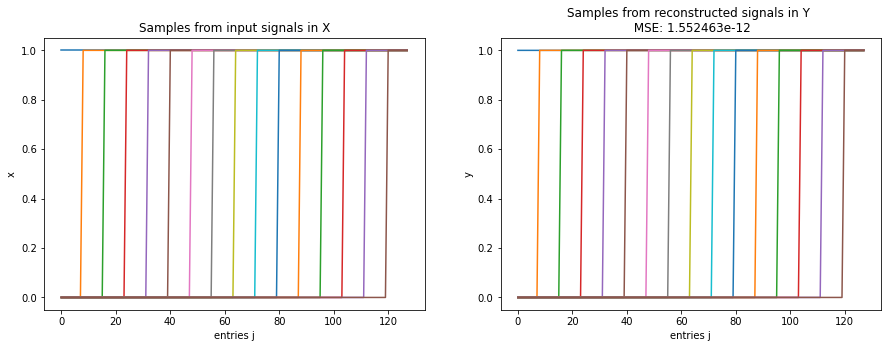

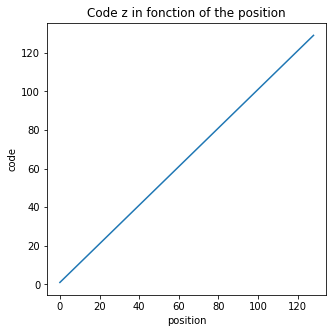

In [7]:
#Computing reconstructions and MSE loss
Y = ae.forward(X_test)
MSE_sigm_sol = torch.mean((Y-X_test)**2)

#Visualising the results
fig1 = plt.figure(figsize = (15,5))

axes = fig1.subplots(1,2)

for i in np.arange(0, n, 8):
  axes[0].plot(X_test[i,:], label = i)
  axes[1].plot(Y[i].detach().numpy().ravel())

axes[0].set_title("Samples from input signals in X")
axes[1].set_title("Samples from reconstructed signals in Y \n MSE: {:e}".format(MSE_sigm_sol))

axes[0].set_xlabel("entries j")
axes[0].set_ylabel("x")

axes[1].set_xlabel("entries j")
axes[1].set_ylabel("y")

#Visualising the code in function of the position
fig2 = plt.figure(figsize = (5,5))
z = ae.encoder.code
plt.plot(z.detach().numpy())

plt.title("Code z in fonction of the position")
plt.xlabel("position")
plt.ylabel("code")

These results verify the proof of the **Proposition 1**.

### 2. Linear encoder fixed and decoder free
Let's now fix the encoder to output an affine code with respect to the position. We fix $W^{[1]} = w(1,...,1)$ where $w$ is learnt together with $b^{[1]}$. We train the encoder to find the right slope $w$ and bias. T

The decoder is totally free and is initialized by random values. The decoder is also trained.

Concerning the optimization, you can choose between SGD and RMSprop. Both lead to a good result. However, RMSprop is much faster.

In [8]:
class Encoder(nn.Module):
   
  def __init__(self, n_in, n_code):
    super(Encoder, self).__init__()
    #Fixing W1
    self.W1 = torch.ones(n_code, n_in, dtype= torch.float)    
    #The slope w is learnable
    self.w = Parameter(torch.randn(1,1, dtype=torch.float)*0.1, requires_grad = True)
    #The bias is also learnable
    self.b1 = Parameter(torch.randn(1, n_code, dtype= torch.float)*0.1, requires_grad = True)
    
  def forward(self, X):
    
    self.code = F.linear(X, self.W1 * self.w, self.b1)
    
    return self.code

In [9]:
class one_layer_Decoder(nn.Module):
   
  def __init__(self, n_code, n_out):
    super(one_layer_Decoder, self).__init__()

    #Both parameters are learnable
    self.W2 = Parameter(torch.rand(n_out, n_code, dtype= torch.float)*0.01, requires_grad = True)
    
    self.b2 = Parameter(torch.rand(1, n_out, dtype= torch.float)*0.01, requires_grad = True)
    
  def forward(self, code):
    
    self.y = torch.sigmoid(F.linear(code, self.W2, self.b2))
    
    return self.y

In [10]:
n=128
#initializing the encoder and decoder
encoder = Encoder(n,1)
decoder = one_layer_Decoder(1, n)

ae = AutoEncoder(encoder, decoder)
ae.track_gradients(track = True)

In [11]:
nb_epochs = 1000000
t=1000

losses = []
avg_loss = np.zeros(t)

alpha = 1e-3
gamma=0.9

for epoch in range(nb_epochs):

  Y = ae.forward(X)
  loss = torch.mean((Y-X)**2) 

  avg_loss[epoch%t] = loss

  loss.backward()

  ae.RMSprop_step(alpha = alpha, gamma=0.9)

  if (epoch + 1 )%t == 0:

    print(f"epoch {epoch + 1} - loss: {avg_loss.mean()}") 

    losses.append(avg_loss.mean())
    

Init RMSprop
epoch 1000 - loss: 0.1276539580821991
epoch 2000 - loss: 0.075667476400733
epoch 3000 - loss: 0.045271716371178626
epoch 4000 - loss: 0.031844050880521536
epoch 5000 - loss: 0.024627841571345926
epoch 6000 - loss: 0.020161078261211513
epoch 7000 - loss: 0.017150864766910672
epoch 8000 - loss: 0.01500464452430606
epoch 9000 - loss: 0.013410461778752505
epoch 10000 - loss: 0.012187366145662964
epoch 11000 - loss: 0.011223053044639528
epoch 12000 - loss: 0.01044464310258627
epoch 13000 - loss: 0.009803292136639356
epoch 14000 - loss: 0.009265426361002029
epoch 15000 - loss: 0.008807376019656659
epoch 16000 - loss: 0.008412077019922436
epoch 17000 - loss: 0.008066959574818611
epoch 18000 - loss: 0.0077626035218127075
epoch 19000 - loss: 0.007491806245408952
epoch 20000 - loss: 0.007248964157421142
epoch 21000 - loss: 0.007029670499265194
epoch 22000 - loss: 0.006830420348327607
epoch 23000 - loss: 0.00664838572498411
epoch 24000 - loss: 0.0064812466306611895
epoch 25000 - loss

MSE loss at epoch 2000 : 4.527172e-02


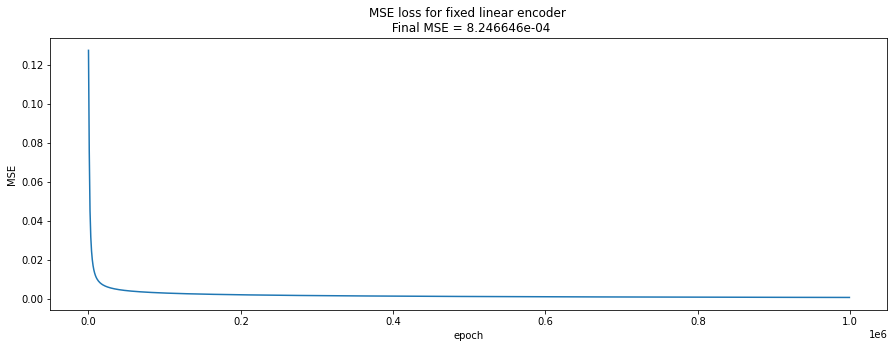

In [13]:
#Plotting the loss curve
plt.figure(figsize=(15,5))

plt.plot(np.arange(len(losses))*t, losses)
plt.title("MSE loss for fixed linear encoder \n Final MSE = {:e}".format(losses[-1]))
plt.xlabel("epoch")
plt.ylabel("MSE")

#Print loss at epoch multiple of t
print("MSE loss at epoch {:d} : {:e}".format(2*t,losses[2]))

Text(0.5, 1.0, 'b2')

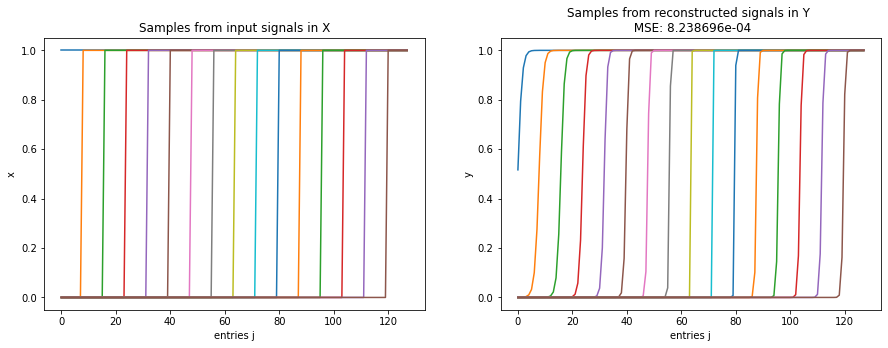

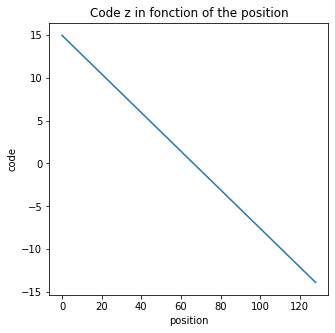

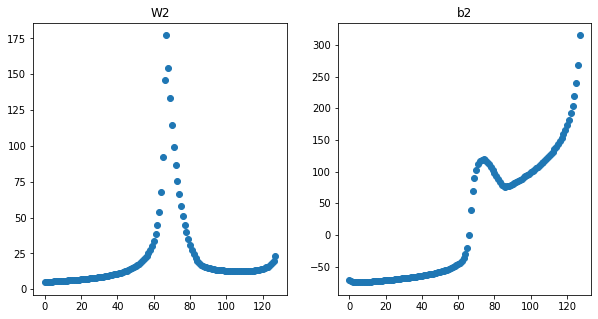

In [14]:
#Computing reconstructions and MSE loss
Y = ae.forward(X_test)
MSE_sigm_fix_encod = torch.mean((Y-X_test)**2)

#Visualising the results
fig1 = plt.figure(figsize = (15,5))

axes = fig1.subplots(1,2)

for i in np.arange(0, n, 8):
  axes[0].plot(X_test[i,:], label = i)
  axes[1].plot(Y[i].detach().numpy().ravel())

axes[0].set_title("Samples from input signals in X")
axes[1].set_title("Samples from reconstructed signals in Y \n MSE: {:e}".format(MSE_sigm_fix_encod))

axes[0].set_xlabel("entries j")
axes[0].set_ylabel("x")

axes[1].set_xlabel("entries j")
axes[1].set_ylabel("y")

#Visualising the code in function of the position
fig2 = plt.figure(figsize = (5,5))
z = ae.encoder.code
plt.plot(z.detach().numpy())

plt.title("Code z in fonction of the position")
plt.xlabel("position")
plt.ylabel("code")

#Visualising the learnt weights for the decoder
fig3 = plt.figure(figsize=(10,5))

axes = fig3.subplots(1,2)

axes[0].scatter(np.arange(n), ae.decoder.W2.detach().numpy())
axes[1].scatter(np.arange(n), ae.decoder.b2.detach().numpy())

axes[0].set_title("W2")
axes[1].set_title("b2")

### 3. Encoder and decoder free
To end the sigmoid part, we will free the encoder and train the entire autoencoder. The purpose of doing so is to observe the linearity of the encoder when set free.

We also use 

In [15]:
class Encoder(nn.Module):
   
  def __init__(self, n_in, n_code):
    super(Encoder, self).__init__()
    #The weights are learnable
    self.W1 = Parameter(torch.rand(n_code, n_in, dtype= torch.float)*0.1, requires_grad = True)    
    #The bias is also learnable
    self.b1 = Parameter(torch.randn(1, n_code, dtype= torch.float)*0.1, requires_grad = True)
    
  def forward(self, X):
    
    self.code = F.linear(X, self.W1, self.b1)
    
    return self.code

In [16]:
class one_layer_Decoder(nn.Module):
   
  def __init__(self, n_code, n_out):
    super(one_layer_Decoder, self).__init__()

    #Both parameters are learnable
    self.W2 = Parameter(torch.rand(n_out, n_code, dtype= torch.float)*0.01, requires_grad = True)
    
    self.b2 = Parameter(torch.rand(1, n_out, dtype= torch.float)*0.01, requires_grad = True)
    
  def forward(self, code):
    
    self.y = torch.sigmoid(F.linear(code, self.W2, self.b2))
    
    return self.y

In [17]:
n=128
#initializing the encoder and decoder
encoder = Encoder(n,1)
decoder = one_layer_Decoder(1, n)

ae = AutoEncoder(encoder, decoder)

In [18]:
nb_epochs = 500000
t=1000

losses = []
avg_loss = np.zeros(t)

alpha = 1
gamma=0.9

for epoch in range(nb_epochs):

  Y = ae.forward(X)
  loss = torch.mean((Y-X)**2) 

  avg_loss[epoch%t] = loss

  loss.backward()

  ae.SGD_step(alpha = alpha)

  if (epoch + 1 )%t == 0:

    print(f"epoch {epoch + 1} - loss: {avg_loss.mean()}") 

    losses.append(avg_loss.mean())
    

epoch 1000 - loss: 0.12725444228947164
epoch 2000 - loss: 0.08170569007098674
epoch 3000 - loss: 0.060850652277469636
epoch 4000 - loss: 0.05030204500630498
epoch 5000 - loss: 0.04411879025772214
epoch 6000 - loss: 0.040054421193897724
epoch 7000 - loss: 0.037160709090530875
epoch 8000 - loss: 0.03392537826672196
epoch 9000 - loss: 0.03055490517243743
epoch 10000 - loss: 0.028166423488408327
epoch 11000 - loss: 0.026355697503313423
epoch 12000 - loss: 0.024957436222583056
epoch 13000 - loss: 0.023792362850159406
epoch 14000 - loss: 0.022814308125525713
epoch 15000 - loss: 0.021964540218934417
epoch 16000 - loss: 0.021216910118237137
epoch 17000 - loss: 0.02055671313405037
epoch 18000 - loss: 0.019979177026078106
epoch 19000 - loss: 0.01942455738224089
epoch 20000 - loss: 0.018943077201023697
epoch 21000 - loss: 0.018503460928797722
epoch 22000 - loss: 0.018098746297881007
epoch 23000 - loss: 0.01771929487772286
epoch 24000 - loss: 0.01735823082923889
epoch 25000 - loss: 0.0170325759556

MSE loss at epoch 2000 : 6.085065e-02


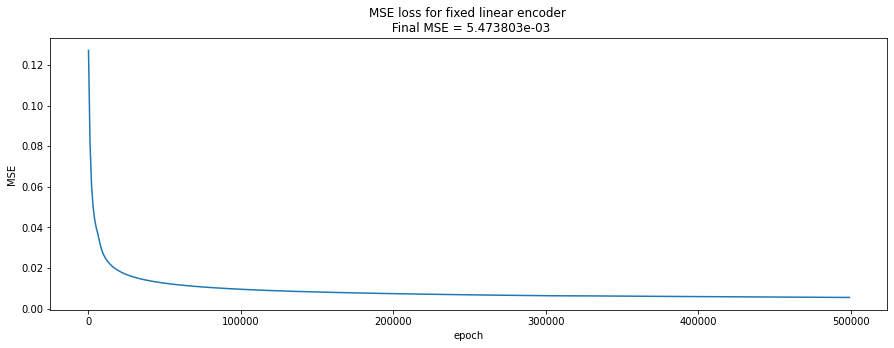

In [19]:
#Plotting the loss curve
plt.figure(figsize=(15,5))

plt.plot(np.arange(len(losses))*t, losses)
plt.title("MSE loss for fixed linear encoder \n Final MSE = {:e}".format(losses[-1]))
plt.xlabel("epoch")
plt.ylabel("MSE")

#Print loss at epoch multiple of t
print("MSE loss at epoch {:d} : {:e}".format(2*t,losses[2]))

Text(0.5, 1.0, 'b2')

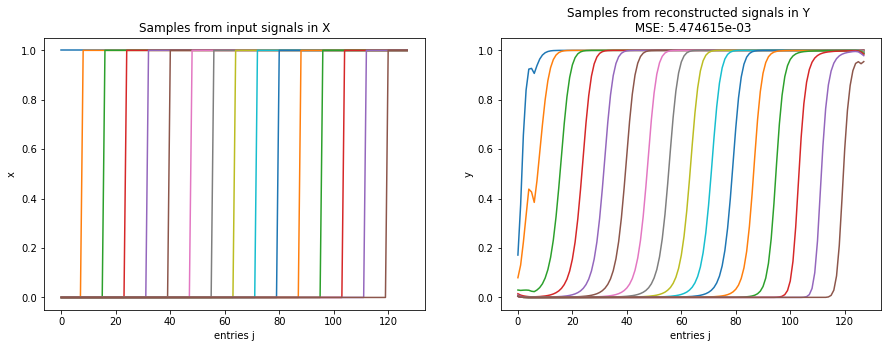

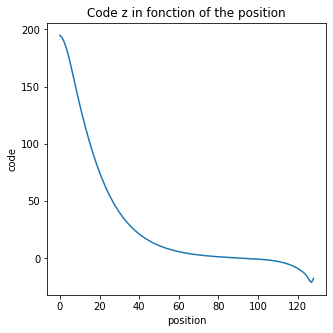

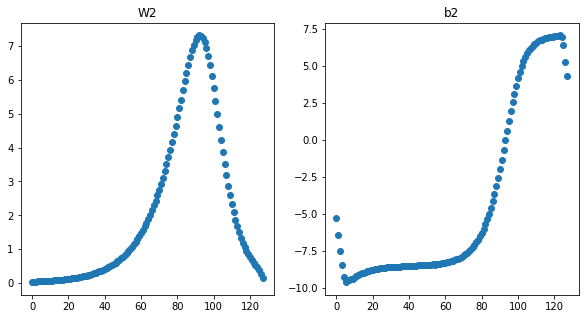

In [20]:
#Computing reconstructions and MSE loss
Y = ae.forward(X_test)
MSE_sigm_free_ae = torch.mean((Y-X_test)**2)

#Visualising the results
fig1 = plt.figure(figsize = (15,5))

axes = fig1.subplots(1,2)

for i in np.arange(0, n, 8):
  axes[0].plot(X_test[i,:], label = i)
  axes[1].plot(Y[i].detach().numpy().ravel())

axes[0].set_title("Samples from input signals in X")
axes[1].set_title("Samples from reconstructed signals in Y \n MSE: {:e}".format(MSE_sigm_free_ae))

axes[0].set_xlabel("entries j")
axes[0].set_ylabel("x")

axes[1].set_xlabel("entries j")
axes[1].set_ylabel("y")

#Visualising the code in function of the position
fig2 = plt.figure(figsize = (5,5))
z = ae.encoder.code
plt.plot(z.detach().numpy())

plt.title("Code z in fonction of the position")
plt.xlabel("position")
plt.ylabel("code")

#Visualising the learnt weights for the decoder
fig3 = plt.figure(figsize=(10,5))

axes = fig3.subplots(1,2)

axes[0].scatter(np.arange(n), ae.decoder.W2.detach().numpy())
axes[1].scatter(np.arange(n), ae.decoder.b2.detach().numpy())

axes[0].set_title("W2")
axes[1].set_title("b2")

## ReLU

In [21]:
class Encoder(nn.Module):
   
  def __init__(self, n_in, n_code):
    super(Encoder, self).__init__()
    #The weights are learnable
    self.W1 = Parameter(torch.randn(n_code, n_in, dtype= torch.float)*0.1, requires_grad = True)    
    #The bias is also learnable
    self.b1 = Parameter(torch.randn(1, n_code, dtype= torch.float)*0.1, requires_grad = True)
    
  def forward(self, X):
    
    self.code = F.linear(X, self.W1, self.b1)
    
    return self.code

In [22]:
class one_layer_Decoder(nn.Module):
   
  def __init__(self, n_code, n_out):
    super(one_layer_Decoder, self).__init__()

    #Both parameters are learnable
    self.W2 = Parameter(torch.rand(n_out, n_code, dtype= torch.float)*0.1, requires_grad = True) 
    
    self.b2 = Parameter(torch.rand(1, n_out, dtype= torch.float)*0.1, requires_grad = True)
    
  def forward(self, code):
    
    self.y = F.relu(F.linear(code, self.W2, self.b2))
    
    return self.y

In [23]:
n=128
#initializing the encoder and decoder
encoder = Encoder(n,1)
decoder = one_layer_Decoder(1, n)

ae = AutoEncoder(encoder, decoder)

In [24]:
nb_epochs = 500000
t=1000

losses = []
avg_loss = np.zeros(t)

alpha = 1e-1
gamma=0.9

for epoch in range(nb_epochs):

  Y = ae.forward(X)
  loss = torch.mean((Y-X)**2) 

  avg_loss[epoch%t] = loss

  loss.backward()

  ae.SGD_step(alpha = alpha)

  if (epoch + 1 )%t == 0:

    print(f"epoch {epoch + 1} - loss: {avg_loss.mean()}") 

    losses.append(avg_loss.mean())
    

epoch 1000 - loss: 0.09360485077649355
epoch 2000 - loss: 0.07674853585660457
epoch 3000 - loss: 0.06915736074745656
epoch 4000 - loss: 0.06418558372184634
epoch 5000 - loss: 0.06067381442338228
epoch 6000 - loss: 0.05798236198723316
epoch 7000 - loss: 0.05578418515622616
epoch 8000 - loss: 0.053918483387678864
epoch 9000 - loss: 0.05229993009194732
epoch 10000 - loss: 0.05087404264882207
epoch 11000 - loss: 0.049606599826365706
epoch 12000 - loss: 0.04847032035142183
epoch 13000 - loss: 0.047445041306316854
epoch 14000 - loss: 0.04651488998904824
epoch 15000 - loss: 0.045666614074259995
epoch 16000 - loss: 0.04488936697691679
epoch 17000 - loss: 0.04417403188720345
epoch 18000 - loss: 0.043513002682477236
epoch 19000 - loss: 0.04290006190165877
epoch 20000 - loss: 0.042329782109707594
epoch 21000 - loss: 0.041797498941421506
epoch 22000 - loss: 0.04129923203587532
epoch 23000 - loss: 0.04083166790381074
epoch 24000 - loss: 0.040391880113631484
epoch 25000 - loss: 0.0399773139692843
ep

MSE loss at epoch 2000 : 6.915736e-02


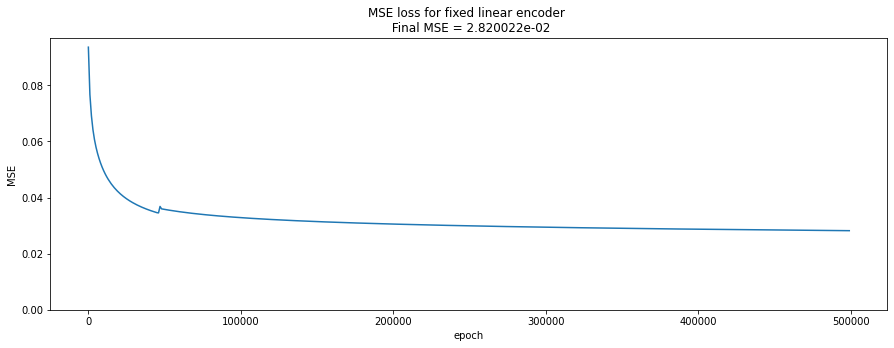

In [25]:
#Plotting the loss curve
plt.figure(figsize=(15,5))

plt.plot(np.arange(len(losses))*t, losses)
plt.title("MSE loss for fixed linear encoder \n Final MSE = {:e}".format(losses[-1]))
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.ylim(ymin=0)

#Print loss at epoch multiple of t
print("MSE loss at epoch {:d} : {:e}".format(2*t,losses[2]))

Text(0.5, 1.0, 'b2')

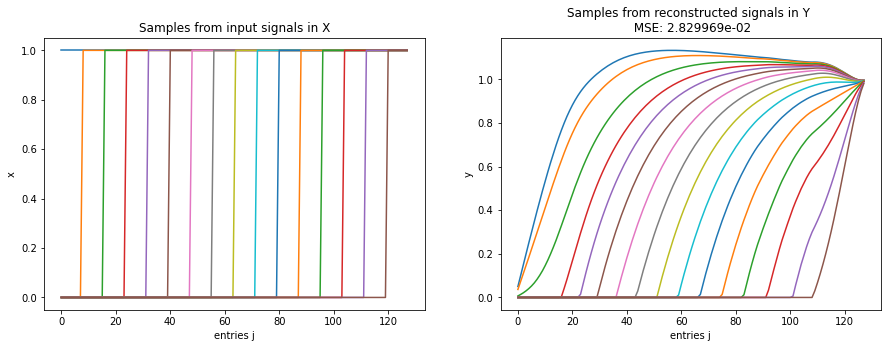

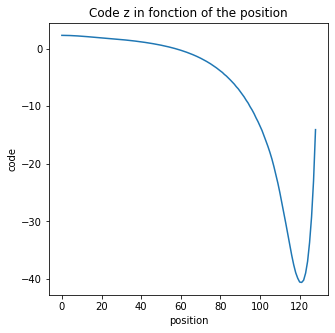

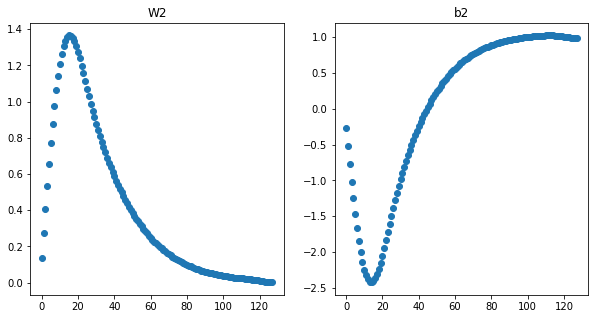

In [26]:
#Computing reconstructions and MSE loss
Y = ae.forward(X_test)
MSE_sigm_free_ae = torch.mean((Y-X_test)**2)

#Visualising the results
fig1 = plt.figure(figsize = (15,5))

axes = fig1.subplots(1,2)

for i in np.arange(0, n, 8):
  axes[0].plot(X_test[i,:], label = i)
  axes[1].plot(Y[i].detach().numpy().ravel())

axes[0].set_title("Samples from input signals in X")
axes[1].set_title("Samples from reconstructed signals in Y \n MSE: {:e}".format(MSE_sigm_free_ae))

axes[0].set_xlabel("entries j")
axes[0].set_ylabel("x")

axes[1].set_xlabel("entries j")
axes[1].set_ylabel("y")

#Visualising the code in function of the position
fig2 = plt.figure(figsize = (5,5))
z = ae.encoder.code
plt.plot(z.detach().numpy())

plt.title("Code z in fonction of the position")
plt.xlabel("position")
plt.ylabel("code")

#Visualising the learnt weights for the decoder
fig3 = plt.figure(figsize=(10,5))

axes = fig3.subplots(1,2)

axes[0].scatter(np.arange(n), ae.decoder.W2.detach().numpy())
axes[1].scatter(np.arange(n), ae.decoder.b2.detach().numpy())

axes[0].set_title("W2")
axes[1].set_title("b2")

## No activation
For the sake of experimenting, let's try to train the autoencoder without any nonlinearity.

In [27]:
class Encoder(nn.Module):
   
  def __init__(self, n_in, n_code):
    super(Encoder, self).__init__()
    #The weights are learnable
    self.W1 = Parameter(torch.rand(n_code, n_in, dtype= torch.float)*0.1, requires_grad = True)    
    #The bias is also learnable
    self.b1 = Parameter(torch.randn(1, n_code, dtype= torch.float)*0.1, requires_grad = True)
    
  def forward(self, X):
    
    self.code = F.linear(X, self.W1, self.b1)
    
    return self.code

In [28]:
class one_layer_Decoder(nn.Module):
   
  def __init__(self, n_code, n_out):
    super(one_layer_Decoder, self).__init__()

    #Both parameters are learnable
    self.W2 = Parameter(torch.rand(n_out, n_code, dtype= torch.float)*0.01, requires_grad = True)
    
    self.b2 = Parameter(torch.rand(1, n_out, dtype= torch.float)*0.01, requires_grad = True)
    
  def forward(self, code):
    
    self.y = F.linear(code, self.W2, self.b2)
    
    return self.y

In [29]:
n=128
#initializing the encoder and decoder
encoder = Encoder(n,1)
decoder = one_layer_Decoder(1, n)

ae = AutoEncoder(encoder, decoder)

In [30]:
nb_epochs = 500000
t=1000

losses = []
avg_loss = np.zeros(t)

alpha = 1e-2
gamma=0.9

for epoch in range(nb_epochs):

  Y = ae.forward(X)
  loss = torch.mean((Y-X)**2) 

  avg_loss[epoch%t] = loss

  loss.backward()

  ae.SGD_step(alpha = alpha)

  if (epoch + 1 )%t == 0:

    print(f"epoch {epoch + 1} - loss: {avg_loss.mean()}") 

    losses.append(avg_loss.mean())
    

epoch 1000 - loss: 0.1365667287260294
epoch 2000 - loss: 0.09302600546181201
epoch 3000 - loss: 0.09142342986166477
epoch 4000 - loss: 0.08995650108903647
epoch 5000 - loss: 0.08858026108145714
epoch 6000 - loss: 0.08727796015143395
epoch 7000 - loss: 0.08604174794256687
epoch 8000 - loss: 0.08486711934953928
epoch 9000 - loss: 0.08375103234499692
epoch 10000 - loss: 0.0826911389529705
epoch 11000 - loss: 0.08168542106449604
epoch 12000 - loss: 0.08073200710862875
epoch 13000 - loss: 0.07982907509058713
epoch 14000 - loss: 0.07897481228411198
epoch 15000 - loss: 0.07816739419102668
epoch 16000 - loss: 0.0774049775376916
epoch 17000 - loss: 0.07668570914119482
epoch 18000 - loss: 0.07600772983580828
epoch 19000 - loss: 0.0753691863566637
epoch 20000 - loss: 0.0747682412788272
epoch 21000 - loss: 0.07420308293402195
epoch 22000 - loss: 0.07367193020880222
epoch 23000 - loss: 0.0731730458214879
epoch 24000 - loss: 0.0727047361433506
epoch 25000 - loss: 0.07226535788923502
epoch 26000 - lo

MSE loss at epoch 2000 : 9.142343e-02


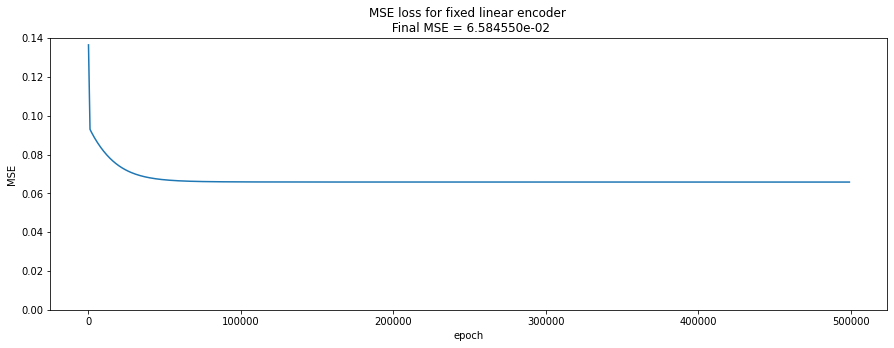

In [31]:
#Plotting the loss curve
plt.figure(figsize=(15,5))

plt.plot(np.arange(len(losses))*t, losses)
plt.title("MSE loss for fixed linear encoder \n Final MSE = {:e}".format(losses[-1]))
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.ylim(ymin=0)

#Print loss at epoch multiple of t
print("MSE loss at epoch {:d} : {:e}".format(2*t,losses[2]))

Text(0.5, 1.0, 'b2')

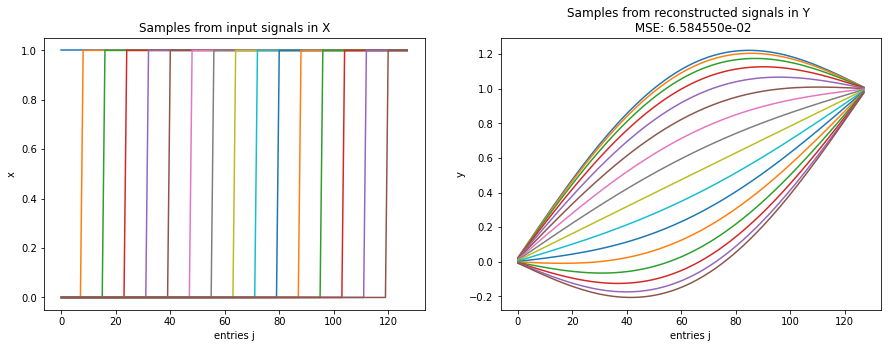

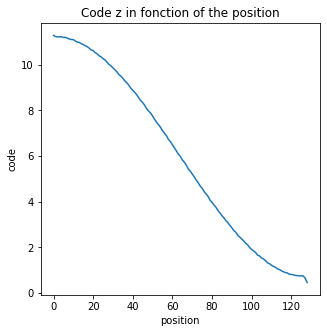

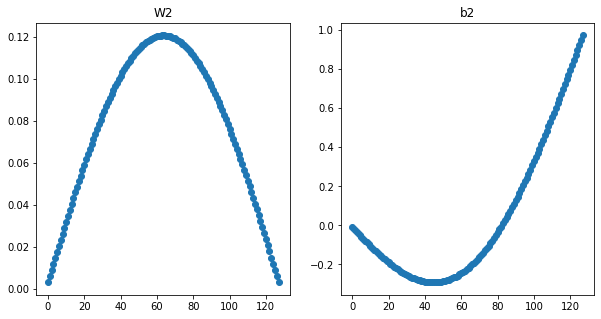

In [32]:
#Computing reconstructions and MSE loss
Y = ae.forward(X_test)
MSE_sigm_free_ae = torch.mean((Y-X_test)**2)

#Visualising the results
fig1 = plt.figure(figsize = (15,5))

axes = fig1.subplots(1,2)

for i in np.arange(0, n, 8):
  axes[0].plot(X_test[i,:], label = i)
  axes[1].plot(Y[i].detach().numpy().ravel())

axes[0].set_title("Samples from input signals in X")
axes[1].set_title("Samples from reconstructed signals in Y \n MSE: {:e}".format(MSE_sigm_free_ae))

axes[0].set_xlabel("entries j")
axes[0].set_ylabel("x")

axes[1].set_xlabel("entries j")
axes[1].set_ylabel("y")

#Visualising the code in function of the position
fig2 = plt.figure(figsize = (5,5))
z = ae.encoder.code
plt.plot(z.detach().numpy())

plt.title("Code z in fonction of the position")
plt.xlabel("position")
plt.ylabel("code")

#Visualising the learnt weights for the decoder
fig3 = plt.figure(figsize=(10,5))

axes = fig3.subplots(1,2)

axes[0].scatter(np.arange(n), ae.decoder.W2.detach().numpy())
axes[1].scatter(np.arange(n), ae.decoder.b2.detach().numpy())

axes[0].set_title("W2")
axes[1].set_title("b2")